In [19]:
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score


In [2]:
data_folder='spaceship-titanic'
data=pd.read_csv(os.path.join(data_folder, 'train.csv'))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Data Cleaning and Preparation

In [6]:
# parse Cabin column into deck, num and side
data['Cabin'] = data['Cabin'].fillna('')
data['CabinDeck']=data['Cabin'].apply(lambda x: x.split('/')[0] if x!='' else '')
data['CabinSide'] = data['Cabin'].apply(lambda x: x.split('/')[2] if x!='' else '')

In [7]:
data['TravelPartnersNum'] = data['PassengerId'].apply(lambda x: int(x.split('_')[1])-1)

In [8]:
drop_columns=['Name','Cabin']
data.drop(columns=drop_columns, inplace=True)

In [9]:
bool_cols=['CryoSleep', 'VIP', 'Transported']
data[bool_cols] = data[bool_cols].astype(bool).astype(int)


In [10]:
cat_cols = ['HomePlanet','Destination', 'CabinDeck', 'CabinSide', 'CryoSleep', 'VIP']

num_cols=['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TravelPartnersNum',
         'CryoSleep', 'VIP']

bool_cols=['CryoSleep', 'VIP']

num_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())])

cat_pipeline=Pipeline([
    ('one_hot_enc', OneHotEncoder()),
    ('imputer', SimpleImputer(strategy='median'))])



pipeline=ColumnTransformer([
    ("num", num_pipeline, num_cols), 
    ("cat", cat_pipeline, cat_cols),
    
])


In [11]:
pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck',
                                  'TravelPartnersNum', 'CryoSleep', 'VIP']),
                                ('cat',
                                 Pipeline(steps=[('one_hot_enc',
                                                  OneHotEncoder()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['HomePlanet', 'Destination', 'CabinDeck',
                                  'CabinSide', 'CryoSleep', 'VIP'])])

In [12]:
data_prepared=pipeline.fit_transform(data)

In [13]:
import numpy as np

enc_cat_features = pipeline.named_transformers_['cat']['one_hot_enc'].get_feature_names()
print(len(enc_cat_features))
print(len(num_cols))
labels = np.concatenate([num_cols, enc_cat_features])

24
9


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
labels

array(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TravelPartnersNum', 'CryoSleep', 'VIP', 'x0_Earth', 'x0_Europa',
       'x0_Mars', 'x0_nan', 'x1_55 Cancri e', 'x1_PSO J318.5-22',
       'x1_TRAPPIST-1e', 'x1_nan', 'x2_', 'x2_A', 'x2_B', 'x2_C', 'x2_D',
       'x2_E', 'x2_F', 'x2_G', 'x2_T', 'x3_', 'x3_P', 'x3_S', 'x4_0',
       'x4_1', 'x5_0', 'x5_1'], dtype=object)

In [15]:
y_train = data.pop('Transported')
X_train = data_prepared.copy()


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Predict with Logistic Regression - baseline

In [371]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()

lr.fit(X_train, y_train)
y_pred=lr.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, y_pred))
print('Precision: ', precision_score(y_val, y_pred))
print('Recall: ', recall_score(y_val, y_pred))


Accuracy:  0.7814836112708453
Precision:  0.7632135306553911
Recall:  0.8223234624145785


In [287]:
params=dict([('penalty',['l1', 'l2', 'elasticnet']),
           ('C',[0.1,0.3,0.5,0.7]),
           ('solver',['liblinear']),
           ('max_iter',[100,250, 500])])
lr2 = LogisticRegression()

clf_lr = GridSearchCV(lr2, params, verbose=3, scoring='accuracy')
clf_lr.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.776 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.796 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.787 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.785 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l1, solver=liblinear;, score=0.805 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.784 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.800 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.786 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.785 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.8

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/homebrew/Caskroom/miniforge/base/

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.3, 0.5, 0.7], 'max_iter': [100, 250, 500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [288]:
clf_lr.best_estimator_

LogisticRegression(C=0.7, penalty='l1', solver='liblinear')

In [372]:
y_pred_lr = clf_lr.best_estimator_.predict(X_val)
accuracy_score(y_val, y_pred_lr)
print('Accuracy: ', accuracy_score(y_val, y_pred_lr))
print('Precision: ', precision_score(y_val, y_pred_lr))
print('Recall: ', recall_score(y_val, y_pred_lr))


Accuracy:  0.7814836112708453
Precision:  0.7632135306553911
Recall:  0.8223234624145785


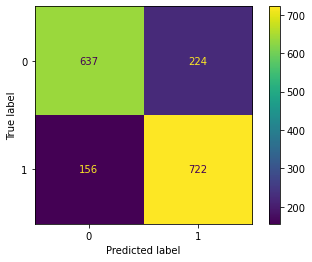

In [290]:
cm = confusion_matrix(y_val, y_pred_lr, labels=clf_lr.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_lr.best_estimator_.classes_)
disp.plot()
plt.show()


# Predict with LGBM

In [20]:
lgbm=LGBMClassifier(learning_rate=0.01, max_depth=4, n_estimators=1000,
               num_leaves=10)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred_lgbm))
print('Precision: ', precision_score(y_val, y_pred_lgbm))
print('Recall: ', recall_score(y_val, y_pred_lgbm
                              ))


Accuracy:  0.78953421506613
Precision:  0.7644628099173554
Recall:  0.8428246013667426


# Param Tuning

In [292]:
from sklearn.model_selection import GridSearchCV
params=dict([('n_estimators',[500, 1000, 10000]),
           ('max_depth',[-1, 4,5]),
           ('num_leaves',[10,31, 50]),
           ('learning_rate',[0.1,0.05, 0.001, 0.01])])
lgbm2 = LGBMClassifier()

clf = GridSearchCV(lgbm2, params, verbose=3, scoring='accuracy')
clf.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=10;, score=0.798 total time=   0.3s
[CV 2/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=10;, score=0.800 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=10;, score=0.806 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=10;, score=0.801 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=10;, score=0.796 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31;, score=0.786 total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31;, score=0.787 total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31;, score=0.796 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=-1, n_e

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.001, 0.01],
                         'max_depth': [-1, 4, 5],
                         'n_estimators': [500, 1000, 10000],
                         'num_leaves': [10, 31, 50]},
             scoring='accuracy', verbose=3)

In [436]:
clf.best_estimator_

LGBMClassifier(learning_rate=0.01, max_depth=4, n_estimators=1000,
               num_leaves=10)

In [294]:
y_pred_lgbm = clf.best_estimator_.predict(X_val)
accuracy_score(y_val, y_pred_lgbm)

0.78953421506613

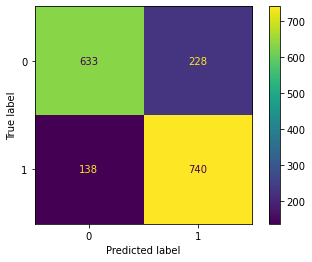

In [296]:

cm = confusion_matrix(y_val, y_pred_lgbm, labels=clf.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.best_estimator_.classes_)
disp.plot()
plt.show()


In [439]:
# calibrate model output
from sklearn.calibration import CalibratedClassifierCV

calibrated_lgbm = CalibratedClassifierCV(base_estimator=clf.best_estimator_, cv=3)
calibrated_lgbm.fit(X_train, y_train)

y_pred_lgbm_calib = calibrated_lgbm.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred_lgbm_calib))
print('Precision: ', precision_score(y_val, y_pred_lgbm_calib))
print('Recall: ', recall_score(y_val, y_pred_lgbm_calib))

Accuracy:  0.7860839562967222
Precision:  0.7602880658436214
Recall:  0.8416856492027335


# Catboost

In [21]:
from catboost import CatBoostClassifier


In [34]:
cat_model=CatBoostClassifier(iterations=1500,
                        depth=4,
                        learning_rate=0.01,
                        loss_function='Logloss',
                        verbose=0)

In [35]:
cat_model.fit(X_train, y_train)

In [24]:

y_pred_cat = cat_model.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_pred_cat))
print('Precision: ', precision_score(y_val, y_pred_cat))
print('Recall: ', recall_score(y_val, y_pred_cat))

Accuracy:  0.7906843013225991
Precision:  0.7671517671517671
Recall:  0.8405466970387244


In [440]:
calibrated_cat = CalibratedClassifierCV(base_estimator=cat_model, cv=3)
calibrated_cat.fit(X_train, y_train)

y_pred_cat_calib = calibrated_cat.predict(X_val)


0:	learn: 0.6896504	total: 1.91ms	remaining: 2.86s
1:	learn: 0.6863566	total: 3.28ms	remaining: 2.46s
2:	learn: 0.6817091	total: 4.55ms	remaining: 2.27s
3:	learn: 0.6784899	total: 6.03ms	remaining: 2.25s
4:	learn: 0.6751061	total: 7.23ms	remaining: 2.16s
5:	learn: 0.6716175	total: 8.59ms	remaining: 2.14s
6:	learn: 0.6679855	total: 10.3ms	remaining: 2.19s
7:	learn: 0.6639935	total: 12.1ms	remaining: 2.26s
8:	learn: 0.6613361	total: 13.6ms	remaining: 2.26s
9:	learn: 0.6582343	total: 15.1ms	remaining: 2.25s
10:	learn: 0.6553184	total: 17.3ms	remaining: 2.35s
11:	learn: 0.6525345	total: 18.9ms	remaining: 2.34s
12:	learn: 0.6495280	total: 20.5ms	remaining: 2.35s
13:	learn: 0.6467026	total: 21.7ms	remaining: 2.3s
14:	learn: 0.6432339	total: 23.1ms	remaining: 2.29s
15:	learn: 0.6402650	total: 24.5ms	remaining: 2.27s
16:	learn: 0.6374740	total: 26.1ms	remaining: 2.28s
17:	learn: 0.6346878	total: 27.6ms	remaining: 2.27s
18:	learn: 0.6316945	total: 28.9ms	remaining: 2.25s
19:	learn: 0.6290734	to

In [441]:
print('Accuracy: ', accuracy_score(y_val, y_pred_cat_calib))
print('Precision: ', precision_score(y_val, y_pred_cat_calib))
print('Recall: ', recall_score(y_val, y_pred_cat_calib))

Accuracy:  0.7878090856814262
Precision:  0.7642782969885774
Recall:  0.8382687927107062


# XG Boost with sklearn API

In [25]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier(max_depth=5,
                      learning_rate=0.001, 
                      
        verbosity=1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
xgb_preds

array([0, 1, 1, ..., 0, 1, 0])

In [26]:
xgb_preds=xgb_model.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, xgb_preds))
# print('Precision: ', precision_score(y_val, xgb_preds))
# print('Recall: ', recall_score(y_val, xgb_preds))


Accuracy:  0.7734330074755607


In [23]:
calibrated_xgb = CalibratedClassifierCV(base_estimator=xgb_model, cv=3)
calibrated_xgb.fit(X_train, y_train)

y_pred_xgb_calib = calibrated_xgb.predict(X_val)


NameError: name 'CalibratedClassifierCV' is not defined

In [443]:
print('Accuracy: ', accuracy_score(y_val, y_pred_xgb_calib))
print('Precision: ', precision_score(y_val, y_pred_xgb_calib))
print('Recall: ', recall_score(y_val, y_pred_xgb_calib))


Accuracy:  0.7740080506037953
Precision:  0.7667766776677668
Recall:  0.7938496583143508


# Random Forest

In [491]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier()
params=dict([('n_estimators', [50,100,500,1000]),
            ('max_depth', [2,3,5,7]),
            ('max_features', ['sqrt', 'log2', None]),
            ('class_weight', ['balanced', 'balanced_subsample'])])

rf_clf=GridSearchCV(rf, params, verbose=3, scoring='accuracy')
rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50;, score=0.720 total time=   0.1s
[CV 2/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50;, score=0.723 total time=   0.1s
[CV 3/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50;, score=0.715 total time=   0.1s
[CV 4/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50;, score=0.715 total time=   0.1s
[CV 5/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=50;, score=0.737 total time=   0.1s
[CV 1/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.721 total time=   0.1s
[CV 2/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.712 total time=   0.1s
[CV 3/5] END class_weight=balanced, max_depth=2, max_features=sqrt, n_estimators=100;, score=0.715 total time=   0.1s

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [2, 3, 5, 7],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 500, 1000]},
             scoring='accuracy', verbose=3)

In [492]:
rf_clf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features=None, n_estimators=50)

In [493]:
rf_preds=rf_clf.best_estimator_.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, rf_preds))
print('Precision: ', precision_score(y_val, rf_preds))
print('Recall: ', recall_score(y_val, rf_preds))

Accuracy:  0.7872340425531915
Precision:  0.7822222222222223
Recall:  0.8018223234624146


# MLP 

In [501]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(random_state=42)

mlp.fit(X_train, y_train)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [502]:
mlp_preds=mlp.predict(X_val)

print('Accuracy: ', accuracy_score(y_val, mlp_preds))
print('Precision: ', precision_score(y_val, mlp_preds))
print('Recall: ', recall_score(y_val, mlp_preds))

Accuracy:  0.7883841288096607
Precision:  0.7701271186440678
Recall:  0.8280182232346242


# AdaBoost

In [483]:
from sklearn.ensemble import AdaBoostClassifier

params=dict([('n_estimators',[100, 500, 1000]),
           ('learning_rate',[0.1,0.05, 0.001, 0.01])])
ada=AdaBoostClassifier(random_state=42)

ada_clf = GridSearchCV(ada, params, verbose=3, scoring='accuracy')
ada_clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.778 total time=   0.3s
[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.788 total time=   0.3s
[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.770 total time=   0.3s
[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.771 total time=   0.3s
[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.787 total time=   0.3s
[CV 1/5] END learning_rate=0.1, n_estimators=500;, score=0.781 total time=   1.4s
[CV 2/5] END learning_rate=0.1, n_estimators=500;, score=0.797 total time=   1.4s
[CV 3/5] END learning_rate=0.1, n_estimators=500;, score=0.788 total time=   1.4s
[CV 4/5] END learning_rate=0.1, n_estimators=500;, score=0.796 total time=   1.5s
[CV 5/5] END learning_rate=0.1, n_estimators=500;, score=0.813 total time=   1.5s
[CV 1/5] END learning_rate=0.1, n_estimators=1000;, score=0.783 total time=   3.1s
[CV 2/5] END learning_rate=0.1, n_es

GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.05, 0.001, 0.01],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=3)

In [484]:
ada_clf.best_estimator_

AdaBoostClassifier(learning_rate=0.1, n_estimators=1000, random_state=42)

In [485]:
ada_preds=ada_clf.best_estimator_.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, ada_preds))
print('Precision: ', precision_score(y_val, ada_preds))
print('Recall: ', recall_score(y_val, ada_preds))

Accuracy:  0.7763082231167338
Precision:  0.7507692307692307
Recall:  0.8337129840546698


# Stacking three models

In [214]:
from sklearn.ensemble import StackingClassifier

In [422]:
final_clf=StackingClassifier(estimators=[ ('xgb', xgb_model),
                                         ('lgbm',clf.best_estimator_),
                                        ('cat', cat_model)], final_estimator=LogisticRegression())

In [423]:
final_clf.fit(X_train, y_train)

0:	learn: 0.6897524	total: 2.02ms	remaining: 3.02s
1:	learn: 0.6853900	total: 3.91ms	remaining: 2.93s
2:	learn: 0.6808861	total: 5.9ms	remaining: 2.94s
3:	learn: 0.6770691	total: 7.53ms	remaining: 2.81s
4:	learn: 0.6738013	total: 9.19ms	remaining: 2.75s
5:	learn: 0.6704791	total: 10.8ms	remaining: 2.69s
6:	learn: 0.6674365	total: 12.6ms	remaining: 2.69s
7:	learn: 0.6635651	total: 14.4ms	remaining: 2.68s
8:	learn: 0.6604584	total: 16.1ms	remaining: 2.67s
9:	learn: 0.6567782	total: 18.1ms	remaining: 2.7s
10:	learn: 0.6537245	total: 20ms	remaining: 2.71s
11:	learn: 0.6503318	total: 21.9ms	remaining: 2.72s
12:	learn: 0.6475975	total: 23.8ms	remaining: 2.72s
13:	learn: 0.6447025	total: 25.4ms	remaining: 2.7s
14:	learn: 0.6419079	total: 27.3ms	remaining: 2.7s
15:	learn: 0.6394466	total: 29.3ms	remaining: 2.71s
16:	learn: 0.6363738	total: 31.4ms	remaining: 2.74s
17:	learn: 0.6336773	total: 33.5ms	remaining: 2.76s
18:	learn: 0.6305343	total: 35.3ms	remaining: 2.75s
19:	learn: 0.6285424	total: 

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.001, max_bin=256,
                                              ma...

In [424]:
y_pred_stack = final_clf.predict(X_val)
accuracy_score(y_val, y_pred_stack)
print('Accuracy: ', accuracy_score(y_val, y_pred_stack))
print('Precision: ', precision_score(y_val, y_pred_stack))
print('Recall: ', recall_score(y_val, y_pred_stack))


Accuracy:  0.7889591719378953
Precision:  0.7642192347466391
Recall:  0.8416856492027335


# Voting Classifier

## Hard

In [36]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('xgb', xgb_model),
                                         ('lgbm',lgbm),
                                        ('cat', cat_model)], voting='hard')
#eclf1 = eclf1.fit(X_train, y_train)

In [495]:
vote_pred = eclf1.predict(X_val)

In [496]:
print('Accuracy: ', accuracy_score(y_val, vote_pred))
print('Precision: ', precision_score(y_val, vote_pred))
print('Recall: ', recall_score(y_val, vote_pred))


Accuracy:  0.7918343875790684
Precision:  0.7756410256410257
Recall:  0.826879271070615


In [450]:
preds = pd.DataFrame(y_val)
preds['xgb'] = xgb_preds
preds['cat'] = y_pred_cat
preds['lgbm'] = y_pred_lgbm
preds

,Transported,xgb,cat,lgbm
304,1,0,0,0
2697,0,1,1,1
8424,0,1,1,1
1672,1,1,0,0
8458,1,1,1,1
...,...,...,...,...
7175,0,1,1,1
3187,1,1,1,1
1302,0,0,0,0
5934,1,1,1,1


# Voting Classifier with hard voting Weighted

In [469]:
from itertools import combinations, permutations
preds_dict={}
n=1
for i in list(permutations(range(1,10),3)):
    if sum(i)==10:
        weights=[0.1*n for n in i]
        weighted_preds=np.sum(preds[['lgbm','cat','xgb']].values*weights, axis=1)
        preds_dict[n]={}
        preds_dict[n]['weights']=weights
        preds_dict[n]['preds']=weighted_preds
        n=n+1

In [475]:
for k, v in preds_dict.items():
    print(v['weights'])
   
    print('Accuracy: ', accuracy_score(y_val, [int(i>0.5) for i in v['preds']]))
    print('')

[0.1, 0.2, 0.7000000000000001]
Accuracy:  0.7734330074755607

[0.1, 0.30000000000000004, 0.6000000000000001]
Accuracy:  0.7734330074755607

[0.1, 0.4, 0.5]
Accuracy:  0.7872340425531915

[0.1, 0.5, 0.4]
Accuracy:  0.7952846463484762

[0.1, 0.6000000000000001, 0.30000000000000004]
Accuracy:  0.7906843013225991

[0.1, 0.7000000000000001, 0.2]
Accuracy:  0.7906843013225991

[0.2, 0.1, 0.7000000000000001]
Accuracy:  0.7734330074755607

[0.2, 0.30000000000000004, 0.5]
Accuracy:  0.7872340425531915

[0.2, 0.5, 0.30000000000000004]
Accuracy:  0.7952846463484762

[0.2, 0.7000000000000001, 0.1]
Accuracy:  0.7906843013225991

[0.30000000000000004, 0.1, 0.6000000000000001]
Accuracy:  0.7734330074755607

[0.30000000000000004, 0.2, 0.5]
Accuracy:  0.7872340425531915

[0.30000000000000004, 0.5, 0.2]
Accuracy:  0.7952846463484762

[0.30000000000000004, 0.6000000000000001, 0.1]
Accuracy:  0.7906843013225991

[0.4, 0.1, 0.5]
Accuracy:  0.7872340425531915

[0.4, 0.5, 0.1]
Accuracy:  0.7952846463484762



In [476]:
optimal_weights=[0.1, 0.5, 0.4]

eclf3 = VotingClassifier(estimators=[('lgbm',clf.best_estimator_),
                                    ('cat', cat_model),
                                    ('xgb', xgb_model)], voting='hard', weights=optimal_weights)
eclf3 = eclf3.fit(X_train, y_train)

0:	learn: 0.6897524	total: 1.86ms	remaining: 2.78s
1:	learn: 0.6853900	total: 3.95ms	remaining: 2.96s
2:	learn: 0.6808861	total: 6.27ms	remaining: 3.13s
3:	learn: 0.6770691	total: 8.52ms	remaining: 3.19s
4:	learn: 0.6738013	total: 10.8ms	remaining: 3.24s
5:	learn: 0.6704791	total: 12.7ms	remaining: 3.16s
6:	learn: 0.6674365	total: 14.6ms	remaining: 3.12s
7:	learn: 0.6635651	total: 16.5ms	remaining: 3.08s
8:	learn: 0.6604584	total: 18.3ms	remaining: 3.03s
9:	learn: 0.6567782	total: 20.3ms	remaining: 3.03s
10:	learn: 0.6537245	total: 22.2ms	remaining: 3s
11:	learn: 0.6503318	total: 23.8ms	remaining: 2.96s
12:	learn: 0.6475975	total: 25.6ms	remaining: 2.93s
13:	learn: 0.6447025	total: 27.6ms	remaining: 2.92s
14:	learn: 0.6419079	total: 29.4ms	remaining: 2.91s
15:	learn: 0.6394466	total: 31.6ms	remaining: 2.93s
16:	learn: 0.6363738	total: 33.7ms	remaining: 2.94s
17:	learn: 0.6336773	total: 35.7ms	remaining: 2.94s
18:	learn: 0.6305343	total: 37.7ms	remaining: 2.94s
19:	learn: 0.6285424	tota

In [477]:
vote_pred_weighted = eclf3.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, vote_pred_weighted))
print('Precision: ', precision_score(y_val, vote_pred_weighted))
print('Recall: ', recall_score(y_val, vote_pred_weighted))


Accuracy:  0.7924094307073031
Precision:  0.7706806282722513
Recall:  0.8382687927107062


## Soft

In [444]:
eclf2 = VotingClassifier(estimators=[('xgb_calib', calibrated_xgb),
                                         ('lgbm_calib',calibrated_lgbm),
                                        ('cat_calib', calibrated_cat)], 
                         voting='soft')
eclf2 = eclf2.fit(X_train, y_train)

0:	learn: 0.6896504	total: 1.93ms	remaining: 2.89s
1:	learn: 0.6863566	total: 3.38ms	remaining: 2.53s
2:	learn: 0.6817091	total: 5.45ms	remaining: 2.72s
3:	learn: 0.6784899	total: 6.77ms	remaining: 2.53s
4:	learn: 0.6751061	total: 8.34ms	remaining: 2.49s
5:	learn: 0.6716175	total: 9.89ms	remaining: 2.46s
6:	learn: 0.6679855	total: 11.2ms	remaining: 2.39s
7:	learn: 0.6639935	total: 12.9ms	remaining: 2.4s
8:	learn: 0.6613361	total: 14.9ms	remaining: 2.47s
9:	learn: 0.6582343	total: 16.3ms	remaining: 2.43s
10:	learn: 0.6553184	total: 17.6ms	remaining: 2.38s
11:	learn: 0.6525345	total: 19.1ms	remaining: 2.37s
12:	learn: 0.6495280	total: 20.5ms	remaining: 2.34s
13:	learn: 0.6467026	total: 21.9ms	remaining: 2.32s
14:	learn: 0.6432339	total: 23.4ms	remaining: 2.32s
15:	learn: 0.6402650	total: 24.9ms	remaining: 2.31s
16:	learn: 0.6374740	total: 26.2ms	remaining: 2.28s
17:	learn: 0.6346878	total: 27.7ms	remaining: 2.28s
18:	learn: 0.6316945	total: 29.2ms	remaining: 2.28s
19:	learn: 0.6290734	to

In [445]:
vote_pred = eclf2.predict(X_val)

In [446]:
print('Accuracy: ', accuracy_score(y_val, vote_pred))
print('Precision: ', precision_score(y_val, vote_pred))
print('Recall: ', recall_score(y_val, vote_pred))


Accuracy:  0.7849338700402531
Precision:  0.7592592592592593
Recall:  0.8405466970387244


# Preprocessing with clustering techniques

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipeln=Pipeline([
("kmeans", KMeans(n_clusters=30)),
    ("ensemble", eclf1)
])

In [38]:
pipeln.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=30)),
                ('ensemble',
                 VotingClassifier(estimators=[('xgb',
                                               XGBClassifier(base_score=0.5,
                                                             booster='gbtree',
                                                             callbacks=None,
                                                             colsample_bylevel=1,
                                                             colsample_bynode=1,
                                                             colsample_bytree=1,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             gamma=0, gpu_id=-1,
                                                     

In [39]:
pipeln.score(X_val, y_val)

0.7786083956296722

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid=dict(kmeans__n_clusters=range(30,60))
grid_clf=GridSearchCV(pipeln, param_grid, cv=3, verbose=3)

grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END .............kmeans__n_clusters=30;, score=0.792 total time=   3.8s
[CV 2/3] END .............kmeans__n_clusters=30;, score=0.792 total time=   3.8s
[CV 3/3] END .............kmeans__n_clusters=30;, score=0.798 total time=   3.7s
[CV 1/3] END .............kmeans__n_clusters=31;, score=0.796 total time=   3.7s
[CV 2/3] END .............kmeans__n_clusters=31;, score=0.788 total time=   3.8s
[CV 3/3] END .............kmeans__n_clusters=31;, score=0.795 total time=   3.8s
[CV 1/3] END .............kmeans__n_clusters=32;, score=0.794 total time=   3.8s
[CV 2/3] END .............kmeans__n_clusters=32;, score=0.792 total time=   3.8s
[CV 3/3] END .............kmeans__n_clusters=32;, score=0.797 total time=   3.8s
[CV 1/3] END .............kmeans__n_clusters=33;, score=0.789 total time=   3.9s
[CV 2/3] END .............kmeans__n_clusters=33;, score=0.787 total time=   3.9s
[CV 3/3] END .............kmeans__n_clusters=33;

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=30)),
                                       ('ensemble',
                                        VotingClassifier(estimators=[('xgb',
                                                                      XGBClassifier(base_score=0.5,
                                                                                    booster='gbtree',
                                                                                    callbacks=None,
                                                                                    colsample_bylevel=1,
                                                                                    colsample_bynode=1,
                                                                                    colsample_bytree=1,
                                                                                    early_stopping_rounds=None,
                                                   

In [52]:
grid_clf.best_params_

{'kmeans__n_clusters': 37}

In [53]:
grid_clf.best_estimator_.score(X_val, y_val)

0.7722829212190915

In [38]:
eclf1.fit(X_train, y_train)

0:	learn: 0.6897524	total: 1.99ms	remaining: 2.98s
1:	learn: 0.6853900	total: 3.86ms	remaining: 2.89s
2:	learn: 0.6808861	total: 5.49ms	remaining: 2.74s
3:	learn: 0.6770691	total: 7.22ms	remaining: 2.7s
4:	learn: 0.6738013	total: 9.02ms	remaining: 2.7s
5:	learn: 0.6704791	total: 10.7ms	remaining: 2.67s
6:	learn: 0.6674365	total: 12.5ms	remaining: 2.67s
7:	learn: 0.6635651	total: 14.2ms	remaining: 2.66s
8:	learn: 0.6604584	total: 16.1ms	remaining: 2.67s
9:	learn: 0.6567782	total: 18ms	remaining: 2.68s
10:	learn: 0.6537245	total: 20.1ms	remaining: 2.72s
11:	learn: 0.6503318	total: 21.8ms	remaining: 2.7s
12:	learn: 0.6475975	total: 23.8ms	remaining: 2.72s
13:	learn: 0.6447025	total: 25.9ms	remaining: 2.75s
14:	learn: 0.6419079	total: 27.7ms	remaining: 2.74s
15:	learn: 0.6394466	total: 29.5ms	remaining: 2.73s
16:	learn: 0.6363738	total: 31.3ms	remaining: 2.73s
17:	learn: 0.6336773	total: 33.4ms	remaining: 2.75s
18:	learn: 0.6305343	total: 35.2ms	remaining: 2.75s
19:	learn: 0.6285424	total:

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.001, max_bin=256,
                                            max_...
                                            max_delta_step=0, max_depth=5,
                                        

In [41]:
kmeans= KMeans(n_clusters=30)
data_clustered=kmeans.fit_transform(X_train, y_train)

In [45]:
eclf1.fit(data_clustered, y_train)

0:	learn: 0.6899276	total: 2.47ms	remaining: 3.71s
1:	learn: 0.6866563	total: 4.48ms	remaining: 3.36s
2:	learn: 0.6829927	total: 6.63ms	remaining: 3.31s
3:	learn: 0.6798599	total: 8.74ms	remaining: 3.27s
4:	learn: 0.6767322	total: 10.9ms	remaining: 3.25s
5:	learn: 0.6738000	total: 13ms	remaining: 3.25s
6:	learn: 0.6710058	total: 14.9ms	remaining: 3.18s
7:	learn: 0.6675868	total: 16.9ms	remaining: 3.16s
8:	learn: 0.6645332	total: 19ms	remaining: 3.15s
9:	learn: 0.6611841	total: 21ms	remaining: 3.13s
10:	learn: 0.6581872	total: 23.1ms	remaining: 3.12s
11:	learn: 0.6551976	total: 25.2ms	remaining: 3.13s
12:	learn: 0.6522761	total: 27.3ms	remaining: 3.12s
13:	learn: 0.6492790	total: 29.5ms	remaining: 3.13s
14:	learn: 0.6467279	total: 32.7ms	remaining: 3.23s
15:	learn: 0.6442639	total: 35.3ms	remaining: 3.27s
16:	learn: 0.6417137	total: 37.3ms	remaining: 3.25s
17:	learn: 0.6391037	total: 39.5ms	remaining: 3.25s
18:	learn: 0.6364069	total: 41.7ms	remaining: 3.25s
19:	learn: 0.6343050	total: 

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.001, max_bin=256,
                                            max_...
                                            max_delta_step=0, max_depth=5,
                                        

In [46]:
val_clustered=kmeans.transform(X_val)
clustered_preds = eclf1.predict(val_clustered)

In [47]:
print('Accuracy: ', accuracy_score(y_val, clustered_preds))
print('Precision: ', precision_score(y_val, clustered_preds))
print('Recall: ', recall_score(y_val, clustered_preds))

Accuracy:  0.7751581368602645
Precision:  0.7533818938605619
Recall:  0.8246013667425968


# Submission

In [44]:
test = pd.read_csv('./spaceship-titanic/test.csv')

In [45]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [46]:
def preprocess_data(preprocessor_pipe, data):
    data['Cabin'] = data['Cabin'].fillna('')
    data['CabinDeck']=data['Cabin'].apply(lambda x: x.split('/')[0] if x!='' else '')
    data['CabinSide'] = data['Cabin'].apply(lambda x: x.split('/')[2] if x!='' else '')
    data['TravelPartnersNum'] = data['PassengerId'].apply(lambda x: int(x.split('_')[1])-1)
    drop_columns=['Name','Cabin']
    data.drop(columns=drop_columns, inplace=True)
    bool_cols=['CryoSleep', 'VIP']
    data[bool_cols] = data[bool_cols].astype(bool).astype(int)
    data_prepared = preprocessor_pipe.transform(data)
    return data_prepared


In [47]:
test_preprocessed = preprocess_data(pipeline, test)

In [54]:
test_pred = grid_clf.best_estimator_.predict(test_preprocessed)

In [504]:
test_pred=eclf1 .predict(test_preprocessed)

In [498]:
test_pred = eclf2.predict(test_preprocessed)

In [478]:
test_pred=eclf3.predict(test_preprocessed)

In [425]:
test_pred = final_clf.predict(test_preprocessed)
test_pred

array([1, 0, 1, ..., 1, 1, 1])

In [55]:
submission = test[['PassengerId']]
submission['Transported'] = test_pred.astype(bool)
submission.to_csv('submission.csv', index=False)

/var/folders/13/mypf120d6gz5n4nv6xpbp1sm0000gn/T/ipykernel_25377/908893641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Transported'] = test_pred.astype(bool)


# Neural Network

In [178]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='sigmoid'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='softmax'))

In [179]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(
    learning_rate=0.001))

In [180]:
history=model.fit(X_train, y_train, epochs=100,
                 validation_data=(X_val,y_val))

Epoch 1/100


2022-08-08 13:01:33.197195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 2s 6ms/step - loss: 0.5826 - val_loss: 0.4792
Epoch 2/100
  1/218 [..............................] - ETA: 1s - loss: 0.5212

2022-08-08 13:01:34.638627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 1s 5ms/step - loss: 0.4586 - val_loss: 0.4502
Epoch 3/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4383 - val_loss: 0.4435
Epoch 4/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4280 - val_loss: 0.4337
Epoch 5/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4227 - val_loss: 0.4337
Epoch 6/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4166 - val_loss: 0.4280
Epoch 7/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4136 - val_loss: 0.4249
Epoch 8/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4089 - val_loss: 0.4234
Epoch 9/100
218/218 [==============================] - 1s 6ms/step - loss: 0.4070 - val_loss: 0.4258
Epoch 10/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4037 - val_loss: 0.4216
Epoch 11/100
218/218 [==============================] - 1s 5ms/step - loss: 0.4007 - val_loss: 0.4197


In [181]:
nn_pred=model.predict(X_val)
accuracy_score(y_val, nn_pred)

2022-08-08 13:03:35.841156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.5048878665899943

In [165]:
nn_pred[0:50]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [6]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="RefillTooSoon Report Analysis", minimal=True)
profile.to_file("RefillTooSoon_report_analysis.html")

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Export report to file: 100%|████████████████████| 1/1 [00:00<00:00, 1020.26it/s]
